## https://www.kaggle.com/sauravjoshi23/text-classification-using-siamesenet-glove


In [21]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv
from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict
from keras.utils import np_utils

import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate,Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [22]:
train_data_file_m = '/data/parush/stance_mohammed/new_train.txt'
test_data_file_m = '/data/parush/stance_mohammed/new_test.txt'
TARGETS_m = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion', 'Donald Trump']
pos_target = 'Donald Trump' #1 label
neg_target = 'Atheism'      # 0 label



In [23]:
def df_gen_mohammed(train_data_file_m,pos_target,pos_target_label,neg_target,neg_target_label ):
    print('The model is learning {} vs {} '.format(pos_target,neg_target))
    df = pd.DataFrame(columns=['text', 'target'])
    with open(train_data_file_m, 'r') as trainfile:
        for line in trainfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            if line[0].strip() != 'ID' and pos_target in line[1].strip():
                tweet = line[2]
                df.loc[len(df)] = [tweet,pos_target_label]
            elif line[0].strip() != 'ID' and neg_target in line[1].strip():
                tweet = line[2]
                df.loc[len(df)] = [tweet,neg_target_label]
    df = df.sample(frac = 1)
    return df

In [24]:
df = df_gen_mohammed(train_data_file_m,pos_target,1,neg_target,0 )

The model is learning Donald Trump vs Atheism 


In [25]:
print("Here is the class distribution \n",df['target'].value_counts())

Here is the class distribution 
 1    530
0    513
Name: target, dtype: int64


# Data Cleaning

In [26]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
print("Cleaning Data")    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]
print("Cleaning Done")

Cleaning Data
Cleaning Done


# Triple Loss

In [27]:
positive_initial = list(df[df['target'] == 1]['clean_text'])
negative_initial = list(df[df['target'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
pos = positive_initial[:]
neg = negative_initial[:]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in pos:
    a = data
    p = random.choice(pos)
    n = random.choice(neg)
    df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in neg:
    a = data
    p = random.choice(neg)
    n = random.choice(pos)
    df2.loc[len(df2)] = [a, p, n, 1, 0]

In [28]:
print("The new DF with anchor, positive, negative, label, class is created. The shape is : ", df2.shape)

The new DF with anchor, positive, negative, label, class is created. The shape is :  (1043, 5)


In [29]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)


In [30]:
print("The X_train = {}, X_val = {}, X_test = {}, y_train = {}, y_val = {}, y_test = {}".format(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape))

The X_train = (667, 3), X_val = (167, 3), X_test = (209, 3), y_train = (667, 2), y_val = (167, 2), y_test = (209, 2)


In [31]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

# Tokenizer

In [32]:
print("Starting to Tokenize and Padding")
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

Starting to Tokenize and Padding


In [33]:
print("Loading Embedding and making embedding_matrix")
embeddings_index = {}
f = open('/data/parush/embeddings/wikipedia/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Loading Embedding and making embedding_matrix
Found 400000 word vectors.


In [34]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        
        embedding_vector = embeddings_index.get(word)
    else:
        embedding_vector = None
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [35]:
print("Embedding matrix shape",embedding_matrix.shape)

Embedding matrix shape (3483, 300)


# Siamese Model

In [36]:
print("Creating Model and Loss Function")
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

Creating Model and Loss Function


In [37]:
def embedding_model():
    network = Sequential()
    network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
    network.add(LSTM(64,return_sequences=True, activation="relu",dropout=0.3))
    network.add(Flatten())
    network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
    network.add(Dropout(0.5))
    network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
    #Force the encoding to live on the d-dimentional hypershpere
    # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    return network


def build_network(base_model):
    input_1 = Input(shape=(train_q1_seq.shape[1],))
    input_2 = Input(shape=(train_q2_seq.shape[1],))
    input_3 = Input(shape=(train_q3_seq.shape[1],))
    
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triplet_loss)([A, P, N])
    model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
    model.compile(loss = identity_loss, optimizer = Adam(0.001))
    return model

In [38]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            2777126     input_4[0][0]                    
                                                                 input_5[0][0]              

In [39]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [40]:
print('Learning from training data and validating from validation data')
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 50, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Learning from training data and validating from validation data
Epoch 1/50
11/11 [==============================] - 10s 630ms/step - loss: 0.3714 - val_loss: 0.2669
Epoch 2/50
11/11 [==============================] - 6s 573ms/step - loss: 0.2307 - val_loss: 0.1888
Epoch 3/50
11/11 [==============================] - 6s 594ms/step - loss: 0.1763 - val_loss: 0.1553
Epoch 4/50
11/11 [==============================] - 6s 598ms/step - loss: 0.1489 - val_loss: 0.1482
Epoch 5/50
11/11 [==============================] - 6s 577ms/step - loss: 0.1238 - val_loss: 0.1312
Epoch 6/50
11/11 [==============================] - 6s 589ms/step - loss: 0.1057 - val_loss: 0.1217
Epoch 7/50
11/11 [==============================] - 6s 562ms/step - loss: 0.0959 - val_loss: 0.1207
Epoch 8/50
11/11 [==============================] - 6s 590ms/step - loss: 0.0781 - val_loss: 0.1174
Epoch 9/50
11/11 [==============================] - 6s 596ms/step - loss: 0.0719 - val_loss: 0.1165
Epoch 10/50
11/11 [================

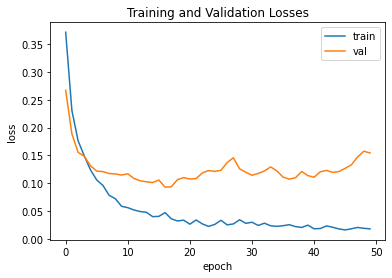

In [41]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [42]:
# model_json = model.to_json()
# with open("siamesemodel-triplet-loss.json", "w") as json_file:
#     json_file.write(model_json)
# #serialize weights to HDF5
# model.save_weights("siamesemodel-triplet-loss.h5")
# print("Saved model to disk")

In [43]:

X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)
# The above embedding outputs will be used to predict. 

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

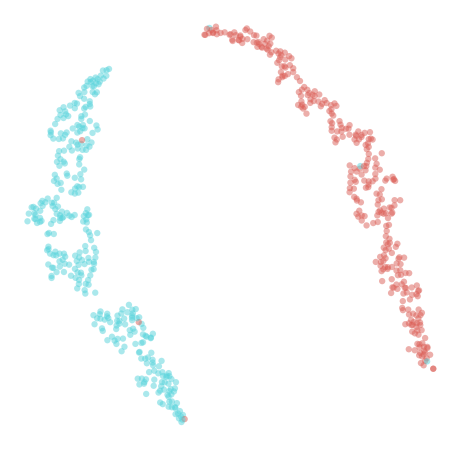

In [44]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [45]:
# classifier that computes the class of a specific embedding for prediction purposes
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = np_utils.to_categorical(y_train_class, 2)
Y_test_onehot = np_utils.to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=100)

Epoch 1/100
21/21 [==============================] - 0s 7ms/step - loss: 0.3568 - accuracy: 0.9880 - val_loss: 0.4742 - val_accuracy: 0.8804
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3475 - accuracy: 0.9880 - val_loss: 0.4699 - val_accuracy: 0.8804
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3387 - accuracy: 0.9895 - val_loss: 0.4658 - val_accuracy: 0.8852
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.9910 - val_loss: 0.4619 - val_accuracy: 0.8852
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.9910 - val_loss: 0.4583 - val_accuracy: 0.8804
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3151 - accuracy: 0.9910 - val_loss: 0.4550 - val_accuracy: 0.8852
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.3079 - accuracy: 0.9910 - val_loss: 0.4517 - val_accuracy: 0.8756
Epoch 8/100
2

In [46]:

input = X_test_eval
y_pred = classifier_model.predict(input)
y_pred=np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test_onehot,axis = 1)
print("Classification report on validation data \n",classification_report(y_test, y_pred, digits=4))



Classification report on validation data 
               precision    recall  f1-score   support

           0     0.8938    0.8783    0.8860       115
           1     0.8542    0.8723    0.8632        94

    accuracy                         0.8756       209
   macro avg     0.8740    0.8753    0.8746       209
weighted avg     0.8760    0.8756    0.8757       209



In [47]:
print("Formating test file for {} vs {} ".format(pos_target,neg_target))
df_test = pd.DataFrame(columns=['text', 'label', 'stance'])
label = 1
for target in [pos_target,neg_target]:
    print('Testing on {} as label {} and'.format(target,label))
    with open(test_data_file_m, 'r') as testfile:
        for line in testfile:
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            if line[0].strip() != 'ID' and target in line[1].strip():
                tweet = line[2]
                df_test.loc[len(df_test)] = [str(tweet),label, line[3]]
    label = 0
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_url(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_emoji(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_html(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_punct(str(x)))
df_test['clean_text'] = df_test['clean_text'].apply(word_tokenize)
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: [word.lower() for word in x])
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df_test['clean_text'] = df_test['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_test['clean_text'] = df_test['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df_test['clean_text'] = [' '.join(map(str, l)) for l in df_test['clean_text']]

Formating test file for Donald Trump vs Atheism 
Testing on Donald Trump as label 1 and
Testing on Atheism as label 0 and


In [48]:
df_test['clean_text'] = df_test['clean_text'].astype(str)
y_q1_seq = t.texts_to_sequences(df_test['clean_text'].values)


y_q1_seq = pad_sequences(y_q1_seq, maxlen=max_len, padding='post')
y_test_eval = base_model.predict(y_q1_seq)

input_2 = y_test_eval
y_pred_2 = classifier_model.predict(input_2)

y2_test_class = np.asarray(df_test['label']).astype('float32')
y2_test_onehot = np_utils.to_categorical(y2_test_class, 2)

y_pred_2=np.argmax(y_pred_2, axis=1)
y_test_2 = np.argmax(y2_test_onehot,axis = 1)
print("")
print("Classification report on Test data \n",classification_report(y_test_2, y_pred_2, digits=4))


Classification report on Test data 
               precision    recall  f1-score   support

           0     0.8957    0.8591    0.8770       220
           1     0.8333    0.8757    0.8540       177

    accuracy                         0.8665       397
   macro avg     0.8645    0.8674    0.8655       397
weighted avg     0.8679    0.8665    0.8668       397



# predicting above model on other target and getting that data

In [49]:
TARGETS_m = [ 'Atheism','Climate Change is a Real Concern', 'Feminist Movement','Hillary Clinton', 'Legalization of Abortion', 'Donald Trump']

In [50]:
test_on = 'Hillary Clinton'

In [51]:
df_oth = pd.DataFrame(columns=['text', 'label', 'stance'])

In [52]:
 with open(train_data_file_m, 'r') as testfile:
        for line in testfile:
            
            line = line.replace('#SemST', '').strip()
            line = line.split('\t')
            
            if line[0].strip() != 'ID' and test_on in line[1].strip():
                tweet = line[2]
                #print(tweet)
                df_oth.loc[len(df_oth)] = [str(tweet),'NA',line[3]]
                

In [53]:
df_oth['clean_text'] = df_oth['text'].apply(lambda x: remove_url(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_emoji(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_html(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: remove_punct(str(x)))
df_oth['clean_text'] = df_oth['clean_text'].apply(word_tokenize)
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: [word.lower() for word in x])
df_oth['clean_text'] = df_oth['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df_oth['clean_text'] = df_oth['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_oth['clean_text'] = df_oth['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df_oth['clean_text'] = [' '.join(map(str, l)) for l in df_oth['clean_text']]

In [54]:
df_oth['stance'][5]

'AGAINST'

In [55]:
df_oth['clean_text'] = df_oth['clean_text'].astype(str)
oth_q1_seq = t.texts_to_sequences(df_oth['clean_text'].values)

In [56]:
oth_q1_seq = pad_sequences(oth_q1_seq, maxlen=max_len, padding='post')
oth_test_eval = base_model.predict(oth_q1_seq)

In [57]:
input_3 = oth_test_eval
oth_pred_3 = classifier_model.predict(input_3)


In [58]:
oth_pred_3

array([[0.29488093, 0.705119  ],
       [0.11479663, 0.8852033 ],
       [0.09600843, 0.9039916 ],
       ...,
       [0.6151274 , 0.38487265],
       [0.47174916, 0.5282509 ],
       [0.04328242, 0.9567176 ]], dtype=float32)

In [59]:
oth_pred_4=np.argmax(oth_pred_3, axis=1)
oth_pred_4

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [60]:
oth_pred_3[0]

array([0.29488093, 0.705119  ], dtype=float32)

In [61]:
unique,count = np.unique(oth_pred_4,return_counts=True)
dict(zip(unique, count))

{0: 97, 1: 592}

# Change the file name 

In [66]:
th = 0.50
df_rich_data= pd.DataFrame(columns = ['Tweet','Stance'])
file_name = 'rich_data/dt_ath_hc/' + pos_target + '_' + neg_target + '_' +test_on + str(th) +'.txt'
with open(file_name,'w') as f:
    for i in range(len(oth_pred_3)):
            if oth_pred_4[i] == 1:
                if oth_pred_3[i][1] >= th:
                    f.write(df_oth['text'][i] + "\t" +df_oth['stance'][i])
                    f.write('\n')

In [46]:
c = 0
with open(file_name,'r') as f:
    for i in f:
        c += 1
c

92

In [67]:
print(file_name)

rich_data/dt_ath_hc/Donald Trump_Atheism_Hillary Clinton0.5.txt


In [71]:
# with open('rich_data.txt','w') as f:
#     for tweet in rich_data:
#         f.write(tweet)
#         f.write('\n')

In [94]:
df_rich_data.to_csv('rich_data.csv',sep='\t')
